In [ ]:
import os
import time
import shutil
import pathlib
import itertools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


Modules loaded


In [ ]:
data_dir = '/content/drive/MyDrive/animals'

# Define functions for data handling
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


In [ ]:
def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

In [ ]:
def split_data(data_dir):
    # Định nghĩa đường dẫn đến các tập tin và các lớp tương ứng
    files, classes = define_paths(data_dir)

    # Tạo một DataFrame từ các tập tin và các lớp
    df = define_df(files, classes)

    # Xác định biến phân loại cho việc phân chia
    strat = df['labels']

    # Chia DataFrame thành các DataFrame huấn luyện và tạm thời (dummy_df)
    # train_size=0.8: Sử dụng 80% dữ liệu cho việc huấn luyện
    # shuffle=True: Trộn dữ liệu trước khi chia
    # random_state=123: Mã số ngẫu nhiên để có thể tái tạo kết quả
    # stratify=strat: Duy trì phân phối lớp tương tự trong các phần chia
    train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

    # Xác định biến phân loại cho phần chia tiếp theo
    strat = dummy_df['labels']

    # Chia DataFrame tạm thời thành các DataFrame validation và test
    # train_size=0.5: Sử dụng 50% dữ liệu còn lại (sau khi train_df) cho validation
    # shuffle=True: Trộn dữ liệu trước khi chia
    # random_state=123: Mã số ngẫu nhiên để có thể tái tạo kết quả
    # stratify=strat: Duy trì phân phối lớp tương tự trong các phần chia
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

    # Trả về các DataFrame huấn luyện, validation, và test
    return train_df, valid_df, test_df

In [ ]:
def create_gens(train_df, valid_df, test_df, batch_size):
    # Kích thước ảnh được sử dụng cho việc đưa vào mô hình
    img_size = (224, 224)
    channels = 3  # Số kênh màu của ảnh
    color = 'rgb'  # Chế độ màu sử dụng: 'rgb' cho màu sắc RGB
    img_shape = (img_size[0], img_size[1], channels)  # Hình dạng của ảnh

    # Hàm để xử lý dữ liệu ảnh
    def scalar(img):
        return img

    # Tạo các đối tượng ImageDataGenerator cho việc tạo dữ liệu huấn luyện và kiểm tra
    tr_gen = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)  # Horizontal flip được sử dụng cho dữ liệu huấn luyện
    ts_gen = ImageDataGenerator(preprocessing_function=scalar)

    # Tạo generator cho dữ liệu huấn luyện từ DataFrame train_df
    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                           color_mode=color, shuffle=True, batch_size=batch_size)

    # Tạo generator cho dữ liệu validation từ DataFrame valid_df
    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                           color_mode=color, shuffle=True, batch_size=batch_size)

    # Tạo generator cho dữ liệu kiểm tra từ DataFrame test_df
    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                          color_mode=color, shuffle=False, batch_size=batch_size)

    # Trả về các generator cho dữ liệu huấn luyện, validation, và test
    return train_gen, valid_gen, test_gen

try:
    # Chia dữ liệu thành các tập huấn luyện, validation, và test
    train_df, valid_df, test_df = split_data(data_dir)

    # Kích thước mỗi batch
    batch_size = 40

    # Tạo các generator cho dữ liệu
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    # In ra thông báo nếu dữ liệu không hợp lệ
    print('Invalid data')


Found 637 validated image filenames belonging to 8 classes.
Found 80 validated image filenames belonging to 8 classes.
Found 80 validated image filenames belonging to 8 classes.


In [ ]:


# Kích thước ảnh và số kênh màu
img_size = (224, 224)
channels = 3

# Hình dạng của ảnh
img_shape = (img_size[0], img_size[1], channels)

# Số lượng lớp class
class_count = len(list(train_gen.class_indices.keys()))

# Tạo một mô hình CNN dựa trên mạng EfficientNetB3 (mô hình được huấn luyện trước)
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# Tạo một mô hình Sequential để kết hợp với mạng EfficientNetB3
model = Sequential([
    base_model,  # Thêm mạng EfficientNetB3 vào mô hình
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),  # Chuẩn hóa batch để cải thiện tốc độ học và ổn định mô hình
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006), activation='relu'),  # Lớp Dense với 256 units, sử dụng hàm kích hoạt ReLU và các hình phạt để kiểm soát overfitting
    Dropout(rate=0.45, seed=123),  # Loại bỏ ngẫu nhiên 45% các units để giảm overfitting
    Dense(class_count, activation='softmax')  # Lớp Dense cuối cùng với hàm kích hoạt softmax để đưa ra dự đoán xác suất của mỗi lớp
])


# Compile mô hình với thuật toán tối ưu Adamax, hàm mất mát là categorical_crossentropy và độ đo là accuracy
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# In thông tin tóm tắt của mô hình
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 128)      

In [ ]:
epochs = 5
history = model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen, shuffle=True)

Epoch 1/5
16/16 [==============================] - 471s 26s/step - loss: 9.2442 - accuracy: 0.4914 - val_loss: 10.4158 - val_accuracy: 0.6625
Epoch 2/5
 7/16 [============>.................] - ETA: 3:50 - loss: 8.0296 - accuracy: 0.8159

In [ ]:
# Độ dài của tập dữ liệu kiểm tra
ts_length = len(test_df)

# Tìm kích thước batch lớn nhất sao cho số lượng batch là tối đa là 80 và chia hết cho độ dài của tập dữ liệu kiểm tra
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

# Số bước trong mỗi epoch cho quá trình đánh giá
test_steps = ts_length // test_batch_size

# Đánh giá mô hình trên tập dữ liệu huấn luyện
train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)

# Đánh giá mô hình trên tập dữ liệu validation
valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)

# Đánh giá mô hình trên tập dữ liệu kiểm tra
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 16s 11s/step - loss: 5.9994 - accuracy: 0.8500
Train Loss:  5.654213905334473
Train Accuracy:  1.0
--------------------
Validation Loss:  6.100199222564697
Validation Accuracy:  0.8500000238418579
--------------------
Test Loss:  5.999360084533691
Test Accuracy:  0.8500000238418579



Original Image Matrix:
[[[ 16  46  27]
  [ 13  42  26]
  [ 16  45  28]
  ...
  [ 53  90  96]
  [ 63  99 109]
  [ 70 105 118]]

 [[ 17  48  30]
  [ 15  46  29]
  [ 15  44  28]
  ...
  [ 59  95 101]
  [ 74 110 120]
  [ 81 116 129]]

 [[ 17  51  34]
  [ 15  48  31]
  [ 16  47  30]
  ...
  [ 69 106 111]
  [ 89 124 133]
  [ 91 125 138]]

 ...

 [[ 40  67 103]
  [ 56  84 119]
  [ 78 112 141]
  ...
  [ 94 126 157]
  [102 131 162]
  [124 156 185]]

 [[ 46  75 112]
  [ 41  71 105]
  [ 77 111 140]
  ...
  [123 157 187]
  [102 132 163]
  [ 94 128 157]]

 [[ 70  97 134]
  [ 56  86 119]
  [ 65  99 128]
  ...
  [132 167 197]
  [113 144 175]
  [ 89 124 152]]]
1/1 [==============================] - 6s 6s/step

Grayscale Image Matrix:
[[ 37  34  37 ...  88  98 105]
 [ 39  37  36 ...  93 109 116]
 [ 42  39  38 ... 103 123 125]
 ...
 [ 75  91 117 ... 132 137 161]
 [ 83  78 116 ... 162 138 133]
 [105  92 104 ... 172 150 128]]

Threshold Image Matrix:
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0  

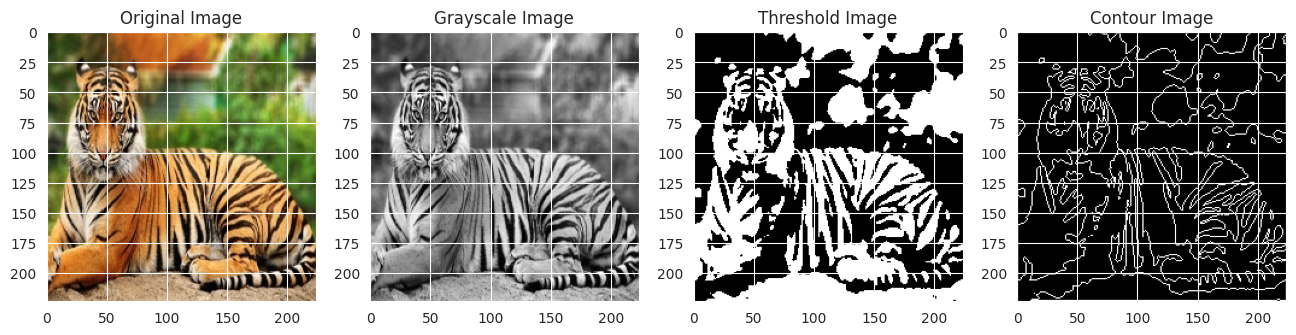

1/1 [==============================] - 0s 425ms/step

This is a Tiger.


In [ ]:
def preprocess_image(image_path):
    # Load ảnh
    image = cv2.imread(image_path)
    # Thay đổi kích thước ảnh đến kích thước mong muốn
    resized_image = cv2.resize(image, (224, 224))
    # Chuyển đổi ảnh sang định dạng float32 và chuẩn hóa
    preprocessed_image = resized_image.astype('float32') / 255.0
    # Chuyển đổi ảnh trở lại định dạng uint8
    preprocessed_image_uint8 = (preprocessed_image * 255).astype('uint8')
    return preprocessed_image_uint8

def visualize_animal(image_path, model):
    try:
        # Tiền xử lý ảnh
        preprocessed_animal_image = preprocess_image(image_path)

        print("\nMa trận Ảnh Gốc:")
        print(preprocessed_animal_image)

        # Trích xuất đặc trưng từ ảnh đã tiền xử lý bằng mô hình đã huấn luyện
        features = model.predict(np.expand_dims(preprocessed_animal_image, axis=0))

        # Tạo ảnh xám
        gray_animal_image = cv2.cvtColor(preprocessed_animal_image, cv2.COLOR_BGR2GRAY)
        print("\nMa trận Ảnh Xám:")
        print(gray_animal_image)

        # Tạo ảnh contour
        blurred_image = cv2.GaussianBlur(gray_animal_image, (5, 5), 0)
        _, threshold_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        print("\nMa trận Ảnh Threshold:")
        print(threshold_image)
        contours, _ = cv2.findContours(threshold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_image = cv2.drawContours(np.zeros_like(gray_animal_image), contours, -1, (255, 255, 255), 1)
        print("\nMa trận Ảnh Contour:")
        print(contour_image)

        # Hiển thị ảnh
        plt.figure(figsize=(16,8))

        # Ảnh gốc
        plt.subplot(1, 4, 1)
        plt.imshow(cv2.cvtColor(preprocessed_animal_image, cv2.COLOR_BGR2RGB))
        plt.title('Ảnh Gốc')

        # Ảnh xám
        plt.subplot(1, 4, 2)
        plt.imshow(gray_animal_image, cmap='gray')
        plt.title('Ảnh Xám')

        # Ảnh Threshold
        plt.subplot(1, 4, 3)
        plt.imshow(threshold_image, cmap='gray')
        plt.title('Ảnh Threshold')

        # Ảnh Contour
        plt.subplot(1, 4, 4)
        plt.imshow(contour_image, cmap='gray')
        plt.title('Ảnh Contour')

        plt.show()

        # Dự đoán xác suất của mỗi lớp sử dụng mô hình đã huấn luyện
        predicted_probabilities = model.predict(np.expand_dims(preprocessed_animal_image, axis=0))

        # Lấy chỉ số lớp dự đoán
        predicted_class_index = np.argmax(predicted_probabilities)

        # Ánh xạ chỉ số lớp dự đoán thành nhãn lớp tương ứng
        class_labels = train_gen.class_indices
        animal_class = [key for key, value in class_labels.items() if value == predicted_class_index][0]

        # In thông tin về loài động vật
        print(f"\nĐây là loài {animal_class}.")

    except Exception as e:
        print(f"Lỗi: {e}")

# Đường dẫn đến ảnh động vật
animal_image = '/content/tiger.jpg'

# Hiển thị ảnh động vật
visualize_animal(animal_image, model)
